## <center> Feature engineering </center>

Nesta fase, será realizada a feature engineering. A partir dos insights obtidos na parte de análise exploratória, serão criadas as seguintes novas features:

1. **Age:** categorizar de 10 em 10 anos e utilizando árvore de decisão. Aplicar log;
2. **Capital gain e loss:** criação de uma indicadora se possui ou não;
3. **hours per week:** aplicar log, categorizar utilizando árvore de decisão e criar uma indicadora se trabalha acima de 40 horas ou não
4. **Race:** gerar duas novas indicadoras - se é branco ou não; se é branco, negro ou outras raças
5. **native country:** gerar uma nova indicadora se é dos EUA ou não.
6. Para as demais categóricas aplicar label ou ordinal encoder

**Nos casos 1, 2 e 3**, como foram observados alguns outliers na análise exploratória, categorizar, ao invés de simplesmente excluir essas observações, é uma forma de não perder informação. Os valores extremos poderiam, também, ser imputados, entretanto como não há uma forma de obter um entendimento mais aprofundado do negócio, este método, bem como a exclusão, poderiam incorrer em substituição/perda de valores legítimos. Nos casos específicos das features **"capital-gain"** e **"capital-loss"**, como a grande maioria dos valores são zero, optou-se por apenas indicar se a pessoa possui ou não valor diferente de zero nestas variáveis.

**Nos casos 4 e 5**, como foi observado que o número de observações em uma categoria era predominante em relação às outras, resolveu-se apenas binarizar as variáveis.

### Importando as libraries necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

from IPython.core.interactiveshell import InteractiveShell
#‘all’, ‘last’, ‘last_expr’ or ‘none’, ‘last_expr_or_assign. Default 'last_expr'
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

### Carregando as bases de treino e teste

In [2]:
df_train = pd.read_csv('df_train_cleaned.csv')

In [3]:
df_train.shape
df_train.head()

(32561, 15)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df_train['income'].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [5]:
df_test = pd.read_csv('df_test_cleaned.csv')

In [6]:
df_test.shape
df_test.head()

(16281, 15)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
df_test['income'].value_counts()

<=50K.    12435
>50K.      3846
Name: income, dtype: int64

### Categorizando a variável "age"

#### Realizando a categorização da variável "age" por faixas de 10 anos

In [8]:
# Definindo uma função para categorizar em faixas de 10 anos e aplicando às bases de treino e teste
def age_group(x):
    x = int(x)
    x = abs(x)
    if( 16 < x < 31 ):
        return 1 #"17-30"
    if( 30 < x < 41 ):
        return 2 #"31-40"
    if( 40 < x < 51 ):
        return 3 #"41-50"
    if( 50 < x < 61 ):
        return 4 #"51-60"
    if( 60 < x < 71 ):
        return 5 #"61-70"
    else:
        return 6 #"Maior que 70"

df_train['age_group'] = df_train['age'].apply(age_group)
df_test['age_group'] = df_test['age'].apply(age_group)

#### Realizando a categorização da variável "age" pelo método tree based
O método tree based utiliza uma árvore de decisão para categorizar a variável preditora. Ele possui a vantagem de levar em conta a relação da variável preditora com a variável target ao sugerir as categorias, a desvantagem é que pode sugerir algumas categorias que não fazem sentido do ponto de vista negocial, então deve ser utlizado com cautela.

In [9]:
# Definindo uma função para encontrar a profundidade ótima (número de categorias) de acordo com algumas métricas de performance.
# Lógico que neste método pode-se tentar diversas variações tanto de parâmetros a serem testados quanto métricas de performance,
# contudo isto pode incorrer em custo de processamento.

def optimal_depth(dataframe, variavel, target, depth=[]):
    score_ls = []     # aqui serão guardados os valores de roc auc
    score_std_ls = [] # aqui serão guardados os valores de desvio padrão do roc_auc
    for tree_depth in depth:
        tree_model = DecisionTreeClassifier(max_depth=tree_depth, random_state = 0)

        scores = cross_val_score(tree_model, dataframe[variavel].to_frame(),       
        dataframe[target], cv=3, scoring='roc_auc')   

        score_ls.append(np.mean(scores))

        score_std_ls.append(np.std(scores))

    temp = pd.concat([pd.Series(depth), pd.Series(score_ls), pd.Series(score_std_ls)], axis=1)
    temp.columns = ['depth', 'roc_auc_mean', 'roc_auc_std']
    return temp

In [10]:
# Definindo uma função para categorizar a variável de acordo com a profundidade sugerida na função acima
def tree_based_categ(df_train, df_test, variavel, target, depth=1, sufix = '_cat_tree'):
    clf = DecisionTreeClassifier(max_depth=depth, random_state = 0)
    clf.fit(df_train[variavel].to_frame(), df_train[target])
    plt.figure(figsize=(7,7))
    tree.plot_tree(clf, filled=True);
    plt.title("Decision tree para a variável "+variavel)
    plt.show()
    df_train['prob_1']=clf.predict_proba(df_train[variavel].to_frame())[:,1]
    df_test['prob_1']=clf.predict_proba(df_test[variavel].to_frame())[:,1]
        
    categorias = pd.concat([df_train.groupby(['prob_1'])[variavel].min().astype(float), df_train.groupby(['prob_1'])[variavel].max().astype(float)], axis=1).reset_index()
    cat_name = variavel+sufix
    categorias[cat_name] = categorias.index
    categorias
    
    if cat_name in df_train.columns:
        df_train = df_train.drop(columns = [cat_name])
    else:
        pass
    if cat_name in df_test.columns:
        df_test = df_test.drop(columns = [cat_name])
    else:
        pass
   
    df_train = pd.merge(df_train,
                        categorias[['prob_1',cat_name]],
                        left_on=['prob_1'],
                        right_on=['prob_1'],
                        how='left')
    df_test = pd.merge(df_test,
                        categorias[['prob_1',cat_name]],
                        left_on=['prob_1'],
                        right_on=['prob_1'],
                        how='left')
    
    df_train = df_train.drop(columns = ['prob_1'])
    df_test = df_test.drop(columns = ['prob_1'])
    display(categorias)
    df_train.groupby([cat_name])[target].count().plot.bar(rot=0)
    
    return df_train, df_test

Aplicando a função para definir a melhor profundidade **(número de categorias)**. No caso abaixo, será **selecionado o depth = 3**, pois após ele não existe um ganho tão alto de auc

In [11]:
optimal_depth(df_train, 'age', 'income', depth=[1,2,3,4,5,6])

,depth,roc_auc_mean,roc_auc_std
0,1,0.653499,0.003950
1,2,0.687455,0.000452
2,3,0.702154,0.002453
3,4,0.708380,0.000882
4,5,0.710249,0.001562
5,6,0.710830,0.000914


Aplicando, na base de treino, o depth ótimo selecionado e **categorizando a variável "age"** nas bases de treino e teste

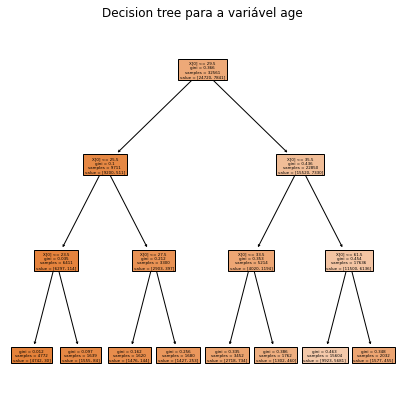

,prob_1,age,age,age_cat_tree
0,0.006287,17.0,23.0,0
1,0.051251,24.0,25.0,1
2,0.088889,26.0,27.0,2
3,0.150595,28.0,29.0,3
4,0.212630,30.0,33.0,4
5,0.223917,62.0,90.0,5
6,0.261067,34.0,35.0,6
7,0.364073,36.0,61.0,7


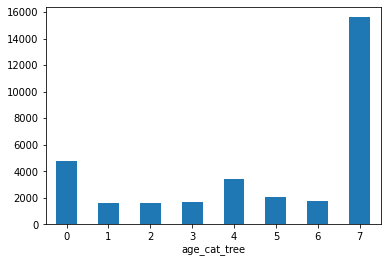

In [12]:
df_train, df_test = tree_based_categ(df_train, df_test, 'age', 'income', depth=3)

<span style="color:red"> **A partir dos resultados acima, resolveu-se realizar uma outra categorização na variável "age", conforme abaixo.**</span>

In [13]:
# Definindo uma função para categorizar em faixas de 10 anos e aplicando às bases de treino e teste
def age_group_2(x):
    x = int(x)
    x = abs(x)
    if( 16 < x <= 35 ):
        return 1 #"17-35"
    if( 35 < x <= 61 ):
        return 3 #"36-61"
    else:
        return 2 #"Maior que 61"

df_train['age_group_2'] = df_train['age'].apply(age_group_2)
df_test['age_group_2'] = df_test['age'].apply(age_group_2)

In [14]:
df_train["age_log"] = np.log(1 + df_train['age'])
df_test["age_log"] = np.log(1 + df_test['age'])

In [15]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,age_cat_tree,age_group_2,age_log
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,2,7,3,3.688879
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,3,7,3,3.931826
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2,7,3,3.663562
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,4,7,3,3.988984
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1,3,1,3.367296


### Criando a variável indicadora se possui ou não capital gain e capital loss

In [16]:
# Definindo uma função para binarizar as variáveis e aplicando às bases de treino e teste
def cont2dummy(x):
    x = int(x)
    x = abs(x)
    if( x == 0 ):
        return 0
    else:
        return 1

df_train['capital_gain_dummy'] = df_train['capital-gain'].apply(cont2dummy)
df_test['capital_gain_dummy'] = df_test['capital-gain'].apply(cont2dummy)

df_train['capital_loss_dummy'] = df_train['capital-loss'].apply(cont2dummy)
df_test['capital_loss_dummy'] = df_test['capital-loss'].apply(cont2dummy)

In [17]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,2,7,3,3.688879,1,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,3,7,3,3.931826,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2,7,3,3.663562,0,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,4,7,3,3.988984,0,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1,3,1,3.367296,0,0


### Hours per week: aplicando log, categorizando com árvore de decisão e criando uma indicadora se trabalha acima de 40 horas ou não

#### Aplicando log

In [18]:
df_train["Hours_per_week_log"] = np.log(1 + df_train['hours-per-week'])
df_test["Hours_per_week_log"] = np.log(1 + df_test['hours-per-week'])

#### Realizando a categorização pelo método tree based
Aplicando a função para definir a melhor profundidade **(número de categorias)**. No caso abaixo, será **selecionado o depth = 2**, pois após ele não existe um ganho tão alto de auc

In [19]:
optimal_depth(df_train, 'hours-per-week', 'income', depth=[1,2,3,4,5,6])

,depth,roc_auc_mean,roc_auc_std
0,1,0.629345,0.003637
1,2,0.668224,0.003097
2,3,0.672823,0.003238
3,4,0.673648,0.003163
4,5,0.674200,0.003013
5,6,0.673664,0.003120


Aplicando, na base de treino, o depth ótimo selecionado e **categorizando a variável "hours-per-week"** nas bases de treino e teste

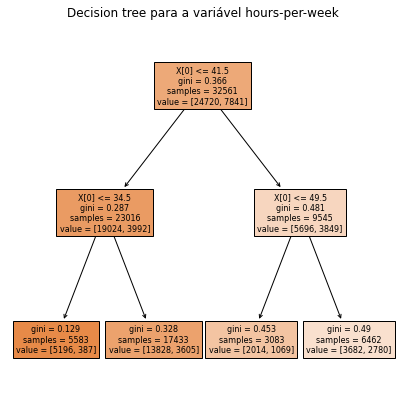

,prob_1,hours-per-week,hours-per-week,hours-per-week_cat_tree
0,0.069318,1.0,34.0,0
1,0.206792,35.0,41.0,1
2,0.346740,42.0,49.0,2
3,0.430207,50.0,99.0,3


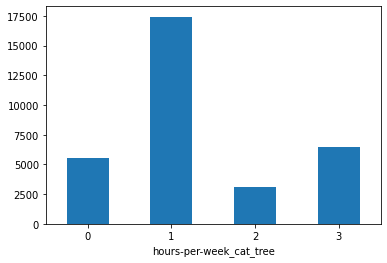

In [20]:
df_train, df_test = tree_based_categ(df_train, df_test, 'hours-per-week', 'income', depth=2)

#### Criando a indicadora se trabalha acima de 40h ou não
O insight de criar esta feature veio após analisar que 75% das pessoas que ganham acima de 50K anuais trabalham acima de 40h semanais, enquanto que 50% das pessoas que ganham abaixo de 50K trabalham acima de 40h semanais.

In [21]:
# Definindo uma função para binarizar a variável e aplicando às bases de treino e teste
def hpw2dummy(x):
    x = int(x)
    x = abs(x)
    if( x <= 40 ):
        return 0
    else:
        return 1

df_train['hours_per_week_acima40'] = df_train['hours-per-week'].apply(hpw2dummy)
df_test['hours_per_week_acima40'] = df_test['hours-per-week'].apply(hpw2dummy)

In [22]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,2,7,3,3.688879,1,0,3.713572,1,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,3,7,3,3.931826,0,0,2.639057,0,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2,7,3,3.663562,0,0,3.713572,1,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,4,7,3,3.988984,0,0,3.713572,1,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1,3,1,3.367296,0,0,3.713572,1,0


### Race: gerando duas novas indicadoras - se é branco ou não; se é branco, negro ou outras raças

#### Gerando a indicadora se é branco ou não

In [23]:
# Definindo uma função para binarizar a variável e aplicando às bases de treino e teste
def race2dummy(x):
    if( x == 'White' ):
        return 1
    else:
        return 0

df_train['race_is_white'] = df_train['race'].apply(race2dummy)
df_test['race_is_white'] = df_test['race'].apply(race2dummy)

#### Gerando a indicadora se é branco, negro ou outras raças

In [24]:
# Definindo uma função para gerar o label para a variável e aplicando às bases de treino e teste
def race2label(x):
    if( x == 'White' ):
        return 3
    if( x == 'Black' ):
        return 2    
    else:
        return 1

df_train['race_is_white_black'] = df_train['race'].apply(race2label)
df_test['race_is_white_black'] = df_test['race'].apply(race2label)

In [25]:
df_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,2,7,3,3.688879,1,0,3.713572,1,0,1,3
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,3,7,3,3.931826,0,0,2.639057,0,0,1,3
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,2,7,3,3.663562,0,0,3.713572,1,0,1,3
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,4,7,3,3.988984,0,0,3.713572,1,0,0,2
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1,3,1,3.367296,0,0,3.713572,1,0,0,2


### Native country: gerando uma nova indicadora se é dos EUA ou não

In [26]:
# Definindo uma função para binarizar a variável e aplicando às bases de treino e teste
def country2dummy(x):
    if( x == 'United-States' ):
        return 1
    else:
        return 0

df_train['native_country_is_eua'] = df_train['native-country'].apply(country2dummy)
df_test['native_country_is_eua'] = df_test['native-country'].apply(country2dummy)

In [27]:
df_test.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.,1,1,1,3.258097,0,0,3.713572,1,0,0,2,1
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.,2,7,3,3.663562,0,0,3.931826,3,1,1,3,1
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.,1,3,1,3.367296,0,0,3.713572,1,0,1,3,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.,3,7,3,3.806662,1,0,3.713572,1,0,0,2,1
4,18,Private,103497,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,30,United-States,<=50K.,1,0,1,2.944439,0,0,3.433987,0,0,1,3,1


### Encoding de variáveis categóricas
A variável "education" não será codificada pois já existe a feature "education-num" que é sua representação codificada. Para as outras será aplicado o label encoder pois não se observa uma ordenação natural entre suas categorias.

In [28]:
var2encoding = ['workclass', 'marital-status', 'occupation', 'relationship', 'sex']

In [29]:
df_train_enc = df_train.copy()
df_test_enc = df_test.copy()
le = LabelEncoder()
for var in var2encoding:
    df_train_enc[var]=le.fit_transform(df_train_enc[var])
    df_test_enc[var]=le.transform(df_test_enc[var])

Codificando, também, a variável target. É uma boa prática codificar como 1 a categoria do evento (ganhar acima de 50K, em nosso estudo), uma vez que será nosso evento a ser estimado. Assim:

In [30]:
def codtarget(x):
    if( x == '<=50K' ):
        return 0
    else:
        return 1
df_train_enc['income'] = df_train_enc['income'].str.replace('.','')
df_test_enc['income'] = df_test_enc['income'].str.replace('.', '')
df_train_enc['income'] = df_train_enc['income'].apply(codtarget)
df_test_enc['income'] = df_test_enc['income'].apply(codtarget)

In [31]:
df_test_enc.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
0,25,3,226802,11th,7,4,6,3,Black,1,0,0,40,United-States,0,1,1,1,3.258097,0,0,3.713572,1,0,0,2,1
1,38,3,89814,HS-grad,9,2,4,0,White,1,0,0,50,United-States,0,2,7,3,3.663562,0,0,3.931826,3,1,1,3,1
2,28,1,336951,Assoc-acdm,12,2,10,0,White,1,0,0,40,United-States,1,1,3,1,3.367296,0,0,3.713572,1,0,1,3,1
3,44,3,160323,Some-college,10,2,6,0,Black,1,7688,0,40,United-States,1,3,7,3,3.806662,1,0,3.713572,1,0,0,2,1
4,18,3,103497,Some-college,10,4,9,3,White,0,0,0,30,United-States,0,1,0,1,2.944439,0,0,3.433987,0,0,1,3,1


Excluindo variáveis que não serão testadas no desenvolvimento do modelo, seja porque não fazem sentido ou porque já foram criadas outras que a representam

In [32]:
vars_to_drop = ['age', 'fnlwgt', 'education', 'race', 'hours-per-week', 'native-country', 'capital-gain', 'capital-loss']
df_train_fe = df_train_enc.drop(vars_to_drop, axis=1)
df_test_fe = df_test_enc.drop(vars_to_drop, axis=1)

In [33]:
df_train_fe.shape
df_train_fe.head()

(32561, 19)

,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
0,6,13,4,0,1,1,0,2,7,3,3.688879,1,0,3.713572,1,0,1,3,1
1,5,13,2,3,0,1,0,3,7,3,3.931826,0,0,2.639057,0,0,1,3,1
2,3,9,0,5,1,1,0,2,7,3,3.663562,0,0,3.713572,1,0,1,3,1
3,3,7,2,5,0,1,0,4,7,3,3.988984,0,0,3.713572,1,0,0,2,1
4,3,13,2,9,5,0,0,1,3,1,3.367296,0,0,3.713572,1,0,0,2,0


### Realizando mais uma rodada de EDA com as novas features que foram criadas

(array([2410., 2362., 4126., 4265., 5161., 5347., 4382., 3172., 1141.,
         195.]),
 array([2.89037176, 3.05242053, 3.21446931, 3.37651808, 3.53856686,
        3.70061563, 3.86266441, 4.02471318, 4.18676196, 4.34881073,
        4.51085951]),
 <BarContainer object of 10 artists>)

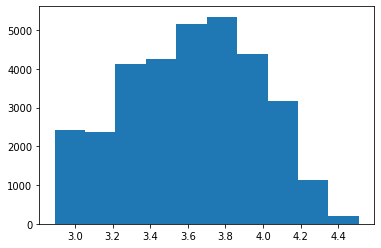

In [35]:
plt.hist(df_train_fe['age_log'])
plt.show() 

(array([   20.,    71.,   114.,   235.,   503.,   761.,  2392., 19502.,
         8158.,   805.]),
 array([0.69314718, 1.08434948, 1.47555178, 1.86675408, 2.25795638,
        2.64915868, 3.04036098, 3.43156328, 3.82276558, 4.21396789,
        4.60517019]),
 <BarContainer object of 10 artists>)

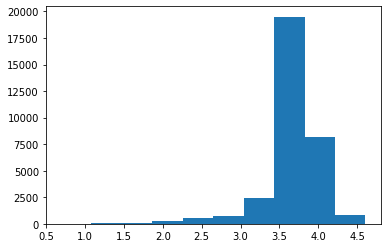

In [36]:
plt.hist(df_train_fe['Hours_per_week_log'])
plt.show() 

A partir dos resultados acima, se observa que, após a transformação logarítimica as distribuições das variáveis "age" e "hours per week" ajustaram um pouco mais, ficando mais próximas de uma distribuição normal, embora esta última ainda apresente um pouco mais de assimetria.

In [39]:
InteractiveShell.ast_node_interactivity = "last_expr"

In [78]:
def graph_dist (df, variavel):
    sns.countplot(x=df[variavel], hue = df['income'], palette='Greens_r', 
                  order = df[variavel].value_counts().index)
    plt.title('Distribuição da variável alvo por '+variavel, fontsize=14)
    plt.xticks(rotation = 90)
    plt.yticks()
    plt.legend()

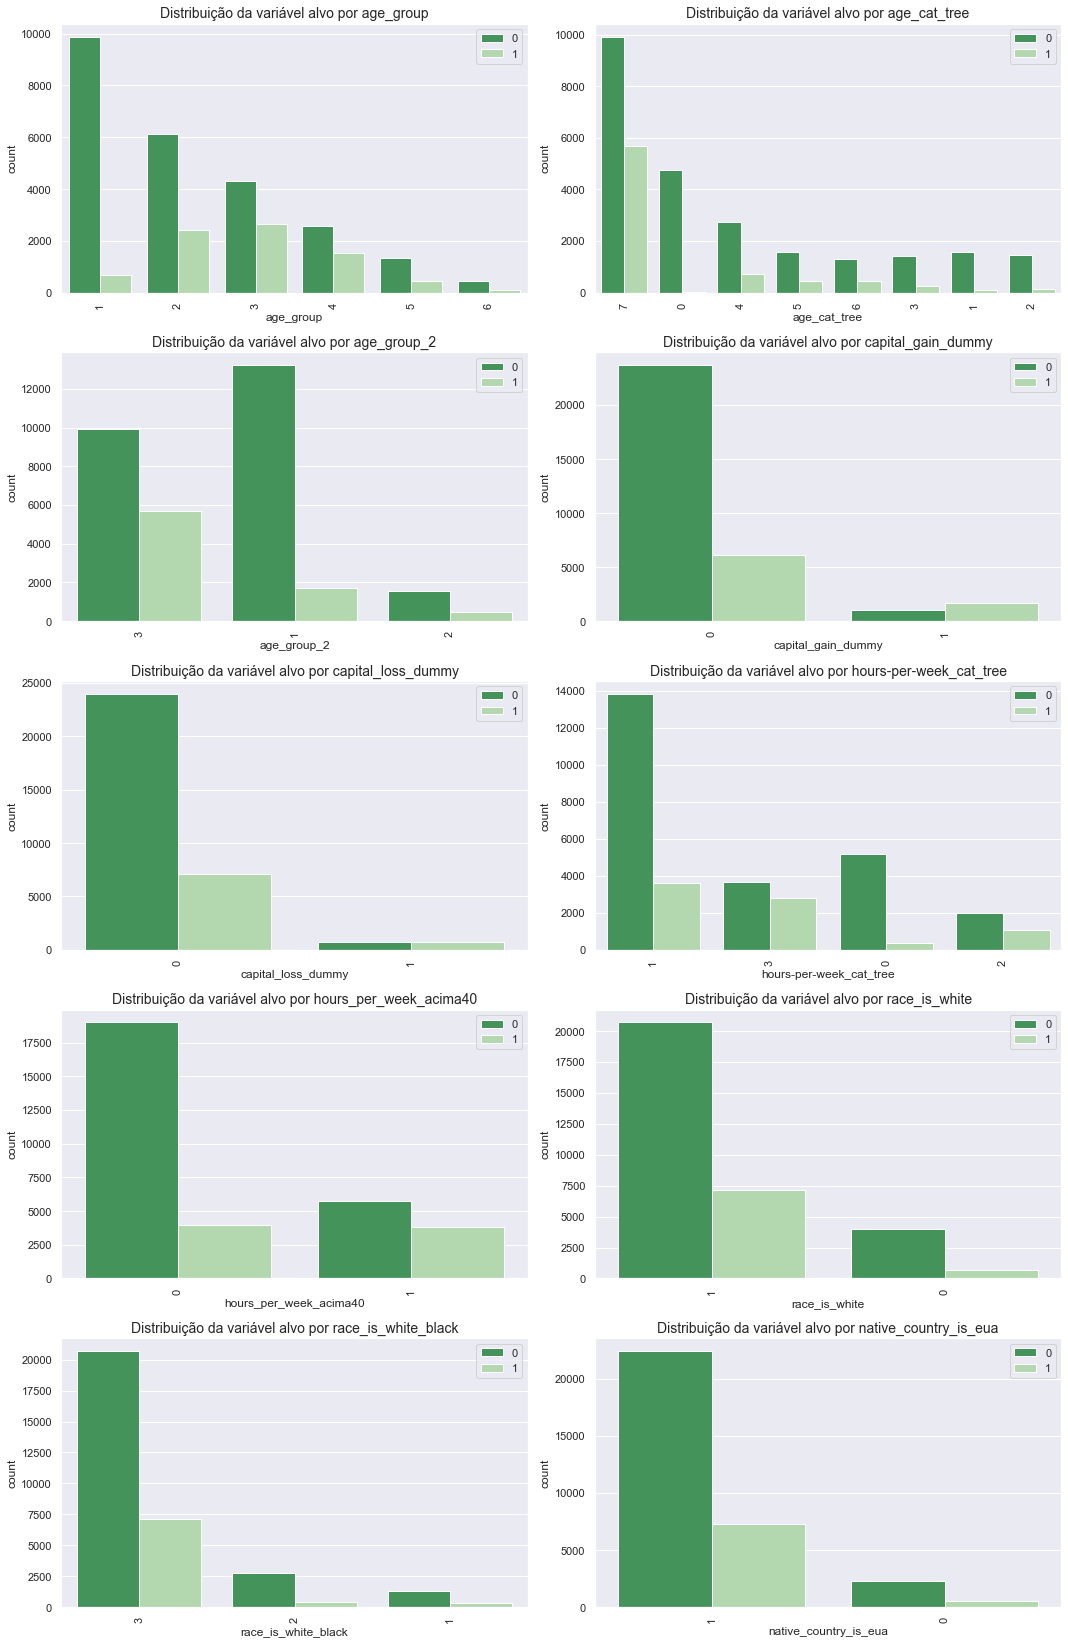

In [79]:
sns.set(rc={"figure.figsize": (15, 23)})

plt.subplot(5,2,1)
graph_dist (df_train_fe, 'age_group')

plt.subplot(5,2,2)
graph_dist (df_train_fe, 'age_cat_tree')

plt.subplot(5,2,3)
graph_dist (df_train_fe, 'age_group_2')

plt.subplot(5,2,4)
graph_dist (df_train_fe, 'capital_gain_dummy')

plt.subplot(5,2,5)
graph_dist (df_train_fe, 'capital_loss_dummy')

plt.subplot(5,2,6)
graph_dist (df_train_fe, 'hours-per-week_cat_tree')

plt.subplot(5,2,7)
graph_dist (df_train_fe, 'hours_per_week_acima40')

plt.subplot(5,2,8)
graph_dist (df_train_fe, 'race_is_white')

plt.subplot(5,2,9)
graph_dist (df_train_fe, 'race_is_white_black')

plt.subplot(5,2,10)
graph_dist (df_train_fe, 'native_country_is_eua')

plt.tight_layout()
plt.show()

In [70]:
def graph_perc (df, variavel):
    x,y = variavel, 'income'

    count_data = (df
                .groupby(x)[y]
                .value_counts(normalize=True)
                .mul(100)
                .rename('percentual')
                .reset_index())
    sns.barplot(x=variavel, y="percentual", hue="income", data=count_data, palette='Greens_r')
    
    plt.title('Percentual de pessoas que ganham abaixo e acima de 50K de acordo com\n as categorias da variável '+variavel, fontsize=14)
    plt.xticks(rotation = 90)
    plt.yticks()
    plt.legend()

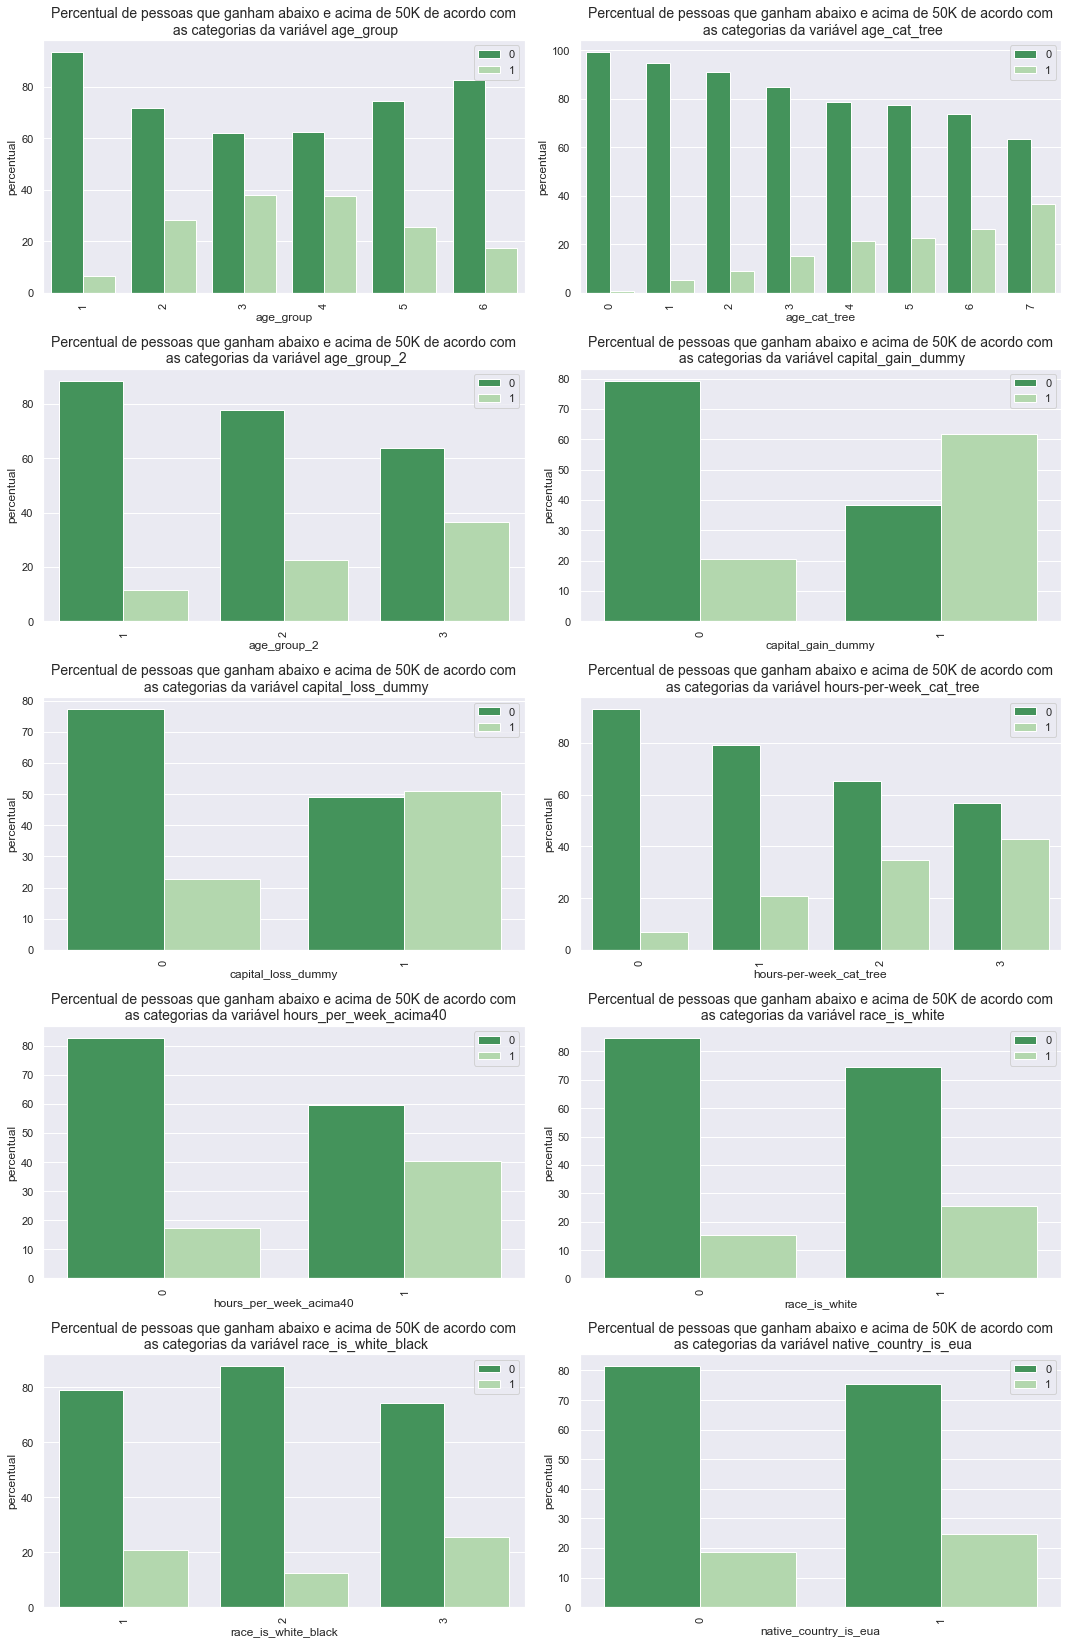

In [71]:
sns.set(rc={"figure.figsize": (15, 23)})

plt.subplot(5,2,1)
graph_perc (df_train_fe, 'age_group')

plt.subplot(5,2,2)
graph_perc (df_train_fe, 'age_cat_tree')

plt.subplot(5,2,3)
graph_perc (df_train_fe, 'age_group_2')

plt.subplot(5,2,4)
graph_perc (df_train_fe, 'capital_gain_dummy')

plt.subplot(5,2,5)
graph_perc (df_train_fe, 'capital_loss_dummy')

plt.subplot(5,2,6)
graph_perc (df_train_fe, 'hours-per-week_cat_tree')

plt.subplot(5,2,7)
graph_perc (df_train_fe, 'hours_per_week_acima40')

plt.subplot(5,2,8)
graph_perc (df_train_fe, 'race_is_white')

plt.subplot(5,2,9)
graph_perc (df_train_fe, 'race_is_white_black')

plt.subplot(5,2,10)
graph_perc (df_train_fe, 'native_country_is_eua')

plt.tight_layout()
plt.show()

A partir dos resultados acima, nota-se que praticamente todas as categorias apresentam mais representatividade em relação às variáveis originais. Ainda, a maioria das novas features parecem promissoras em diferenciar os grupos dos que ganham acima e abaixo de 50K anuais .

### Realizando uma última visão geral nos dados e salvando para a fase de modelagem

In [82]:
InteractiveShell.ast_node_interactivity = "all"

In [83]:
df_train_fe.shape
df_train_fe.head()

(32561, 19)

,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
0,6,13,4,0,1,1,0,2,7,3,3.688879,1,0,3.713572,1,0,1,3,1
1,5,13,2,3,0,1,0,3,7,3,3.931826,0,0,2.639057,0,0,1,3,1
2,3,9,0,5,1,1,0,2,7,3,3.663562,0,0,3.713572,1,0,1,3,1
3,3,7,2,5,0,1,0,4,7,3,3.988984,0,0,3.713572,1,0,0,2,1
4,3,13,2,9,5,0,0,1,3,1,3.367296,0,0,3.713572,1,0,0,2,0


In [84]:
df_test_fe.shape
df_test_fe.head()

(16281, 19)

,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
0,3,7,4,6,3,1,0,1,1,1,3.258097,0,0,3.713572,1,0,0,2,1
1,3,9,2,4,0,1,0,2,7,3,3.663562,0,0,3.931826,3,1,1,3,1
2,1,12,2,10,0,1,1,1,3,1,3.367296,0,0,3.713572,1,0,1,3,1
3,3,10,2,6,0,1,1,3,7,3,3.806662,1,0,3.713572,1,0,0,2,1
4,3,10,4,9,3,0,0,1,0,1,2.944439,0,0,3.433987,0,0,1,3,1


In [93]:
df_train_fe.describe()
df_test_fe.describe()

,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,3.094438,10.080679,2.611836,6.138755,1.446362,0.669205,0.240810,2.374774,4.719972,2.020853,3.618360,0.083290,0.046651,3.665366,1.320138,0.294248,0.854274,2.804490,0.913762
std,1.107194,2.572720,1.506222,3.972708,1.606771,0.470506,0.427581,1.290935,2.668756,0.968085,0.350031,0.276324,0.210893,0.387014,0.978530,0.455711,0.352837,0.506814,0.280720
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.890372,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,9.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,3.367296,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
50%,3.000000,10.000000,2.000000,6.000000,1.000000,1.000000,0.000000,2.000000,6.000000,2.000000,3.637586,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
75%,3.000000,12.000000,4.000000,9.000000,3.000000,1.000000,0.000000,3.000000,7.000000,3.000000,3.891820,0.000000,0.000000,3.828641,2.000000,1.000000,1.000000,3.000000,1.000000
max,7.000000,16.000000,6.000000,13.000000,5.000000,1.000000,1.000000,6.000000,7.000000,3.000000,4.510860,1.000000,1.000000,4.605170,3.000000,1.000000,1.000000,3.000000,1.000000


,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
count,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,3.110128,10.072907,2.632578,6.180947,1.437135,0.667035,0.236226,2.399054,4.714514,2.019348,3.621704,0.081260,0.046864,3.662819,1.316627,0.293041,0.856581,2.809041,0.917388
std,1.117966,2.567545,1.510611,3.961058,1.592903,0.471289,0.424776,1.313938,2.668787,0.964700,0.354030,0.273243,0.211355,0.392120,0.978415,0.455171,0.350510,0.499589,0.275303
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.890372,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,9.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,3.367296,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
50%,3.000000,10.000000,2.000000,7.000000,1.000000,1.000000,0.000000,2.000000,6.000000,2.000000,3.637586,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
75%,3.000000,12.000000,4.000000,9.000000,3.000000,1.000000,0.000000,3.000000,7.000000,3.000000,3.891820,0.000000,0.000000,3.828641,2.000000,1.000000,1.000000,3.000000,1.000000
max,7.000000,16.000000,6.000000,13.000000,5.000000,1.000000,1.000000,6.000000,7.000000,3.000000,4.510860,1.000000,1.000000,4.605170,3.000000,1.000000,1.000000,3.000000,1.000000


In [91]:
# Distribuição de eventos e não eventos nas bases de treino e teste
perc_target_train = df_train_fe.groupby(['income']).agg({'income': 'count'}).apply(lambda x:100 * x / float(x.sum()), axis=0).transpose()
print("\033[1m" + '% de eventos e não eventos na base de treino'+ "\033[0m")
perc_target_train

perc_target_test = df_test_fe.groupby(['income']).agg({'income': 'count'}).apply(lambda x:100 * x / float(x.sum()), axis=0).transpose()
print("\033[1m" +'% de eventos e não eventos na base de teste'+ "\033[0m"+ "\033[0m")
perc_target_test

% de eventos e não eventos na base de treino


income,0,1
income,75.919044,24.080956


% de eventos e não eventos na base de teste


income,0,1
income,76.377372,23.622628


In [92]:
df_train_fe.to_csv('df_train2modelling.csv', index=False)
df_test_fe.to_csv('df_test2modelling.csv', index=False)